# GANs For Generating Photos With Monet Style Transfer

This is an implementation of the CycleGAN architecture to perform style transfer of Monet paintings onto new unrelated images. We will use Tensorflow and Keras models to build the different components of the CycleGAN and generate the images that will be submitted to the competition. 

Use of a TPU (configured in the cell below) is really helpful in training this architecture because traing on CPU would take far too long and Kaggle is generous enough to allow users up to 20 hours of TPU time for free.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import shutil
import pandas as pd

from kaggle_datasets import KaggleDatasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

%matplotlib inline

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

## Preparing Training / Test Data & Image EDA

This project is a little differenet than the others that we've done for this course in that the training data is a rather small set of images. Also we're not trying to classify anything but trying to generate new data that resembles existing data. Consequently, the EDA will concentrate on exploring some aspects of the training data (Monet paintings) and just examing how the images we'll be transferring style to differ. 

An unique feature of this challenge is that we're working not with individual image files but with images stored in the optimized TF Record format. These files store 60 images (Monet files) or 352 images (test images) per file. Just to access these images we have to figure out how to work with the format. 

There are 300 Monet images in the training dataset and 7028 images in the test dataset.

In [8]:
# This is the path to the TF Record formatted files
train_loc_tfrec = '/kaggle/input/monet-gan-getting-started/monet_tfrec'
test_loc_tfrec = '/kaggle/input/monet-gan-getting-started/photo_tfrec'

monet_images_tfrec = tf.io.gfile.glob(str(train_loc_tfrec + '/*.tfrec'))
print(f'There are {len(monet_images_tfrec)} tfrec files with Monet Images For Training')

test_images_tfrec = tf.io.gfile.glob(str(test_loc_tfrec + '/*.tfrec'))
print(f'There are {len(test_loc_tfrec)} tfrec files with Test images for Style Transfer')

There are 5 tfrec files with Monet Images For Training
There are 51 tfrec files with Test images for Style Transfer


In [9]:
tfrecord_dict_format = {"image_name": tf.io.FixedLenFeature([], tf.string),
                        "image": tf.io.FixedLenFeature([], tf.string),
                        "target": tf.io.FixedLenFeature([], tf.string)}

def read_tfrecord(tfrec_file):
    img_data_dict = tf.io.parse_single_example(tfrec_file, tfrecord_dict_format)
    image = tf.image.decode_jpeg(img_data_dict['image'], channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*[256, 256], 3])
    return image

In [10]:
# Extract images from the tfrec files
def load_tfrec_dataset(paths, labeled=True): # removed_arguments , ordered=False
    dataset = tf.data.TFRecordDataset(paths)
    dataset = dataset.map(read_tfrecord) # removed , num_parallel_calls=AUTOTUNE
    return dataset

monet_tf_ds = load_tfrec_dataset(monet_images_tfrec, labeled=True).batch(1)
test_tf_ds = load_tfrec_dataset(test_images_tfrec, labeled=True).batch(1)

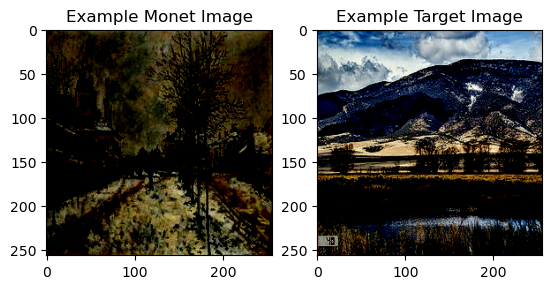

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('Example Monet Image')
axs[0].imshow(next(iter(monet_tf_ds))[0])
axs[1].set_title('Example Target Image')
axs[1].imshow(next(iter(test_tf_ds))[0])
plt.show()

# Model Building

Two components of our CycleGAN:

Generator - The model that generates the new images

Discriminator - The model that judges if the image is real or not

I'll be using instance normalization, which is a Tensorflow add-on.

Images are processed by upsampling and downsampling into different sizes to generate real/fake images. 

In [8]:
def downsample(filters, size, add_instance_norm=True):
    """
    downsamples an image.
    """
    scaler = keras.Sequential()
    scaler.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(0.0, 0.025),
                             use_bias=False))

    if add_instance_norm == True:
        scaler.add(tfa.layers.InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.025)))

    scaler.add(layers.ReLU()) # was LeakyRelu

    return scaler

def upsample(filters, size, add_dropout=False):
    """
    upsamples a downsampled image back to it's original size.
    """
    scaler = keras.Sequential()
    scaler.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.025),
                                      use_bias=False))

    scaler.add(tfa.layers.InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.025)))

    if add_dropout == True:
        scaler.add(layers.Dropout(0.5))

    scaler.add(layers.ReLU()) 

    return scaler

### Define Generator

The generator downsamples/upsamples with long skip connections to deal with vanishing gradients. 

In [10]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    downsample_sequence = [downsample(64, 4, add_instance_norm=False), 
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4), 
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4), 
        downsample(512, 4)]

    upsample_sequence = [upsample(512, 4, add_dropout=True), 
        upsample(512, 4, add_dropout=True),
        upsample(512, 4, add_dropout=True),
        upsample(512, 4), 
        upsample(256, 4), 
        upsample(128, 4),
        upsample(64, 4)]
    
    transpose_conv = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer= tf.random_normal_initializer(0., 0.02),
                                  activation='tanh')

    # Downsampling the model
    skip_connections = []
    for d in downsample_sequence:
        inputs = d(inputs)
        skip_connections.append(inputs)

    skip_connections = reversed(skip_connections[:-1])

    # Upsampling and establishing the skip connections
    for u, skip in zip(upsample_sequence, skip_connections):
        inputs = u(inputs)
        inputs = layers.Concatenate()([inputs, skip])

    inputs = transpose_conv(inputs)

    return keras.Model(inputs=inputs, outputs=inputs)

# Build the discriminator

The discriminator classifies the input image as either real or fake. 

In [11]:
def Discriminator():
    inputs = layers.Input(shape = [256, 256, 3], name = 'input_image')

    d1 = downsample(64, 4, add_instance_norm = False)(inputs)
    d2 = downsample(128, 4)(d1) 
    d3 = downsample(256, 4)(d2) 

    zero_pad1 = layers.ZeroPadding2D()(d3)
    conv1 = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=tf.random_normal_initializer(0.0, 0.025),
                         use_bias=False)(zero_pad1)

    norm = tfa.layers.InstanceNormalization(gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.025))(conv1)
    leaky_relu = layers.LeakyReLU()(norm)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    conv2 = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=tf.random_normal_initializer(0.0, 0.025))(zero_pad2) 

    return tf.keras.Model(inputs = inputs, outputs = conv2)

### Instantiate Generators and Discriminators Within Scope of TPUs

We're now ready to start building and compiling our model. 

In [12]:
with strategy.scope():
    monet_generator = Generator() 
    image_generator = Generator() 

    monet_discriminator = Discriminator() 
    image_discriminator = Discriminator() 

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [14]:
class CycleGan(keras.Model):
    def __init__(self,
        monet_generator,
        image_generator,
        monet_discriminator,
        image_discriminator,
        lambda_cycle=10):
        
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = image_generator
        self.m_disc = monet_discriminator
        self.p_disc = image_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn):
        
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_image = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            gen_monet = self.m_gen(real_image, training=True)
            cycled_image = self.p_gen(gen_monet, training=True)

            # Cycle Monet images
            gen_image = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(gen_image, training=True)

            # Generate from same image
            same_monet = self.m_gen(real_monet, training=True)
            same_image = self.p_gen(real_image, training=True)

            # Discriminator with real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_image = self.p_disc(real_image, training=True)

            # Discriminator checks with generated images
            disc_gen_monet = self.m_disc(gen_monet, training=True)
            disc_gen_image = self.p_disc(gen_image, training=True)

            # Generator loss
            monet_gen_loss = self.gen_loss_fn(disc_gen_monet)
            image_gen_loss = self.gen_loss_fn(disc_gen_image)

            # Total Cycle-Consistency Loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_image, cycled_image, self.lambda_cycle)

            # Generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_image_gen_loss = image_gen_loss + total_cycle_loss + self.identity_loss_fn(real_image, same_image, self.lambda_cycle)

            # Discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_gen_monet)
            image_disc_loss = self.disc_loss_fn(disc_real_image, disc_gen_image)

        # Gradients for generator and discriminator loss
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        image_generator_gradients = tape.gradient(total_image_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        image_discriminator_gradients = tape.gradient(image_disc_loss, self.p_disc.trainable_variables)

        # Optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(image_generator_gradients,self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(image_discriminator_gradients,self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "test_image_gen_loss": total_image_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "test_image_disc_loss": image_disc_loss
        }

# Loss Functions

Discriminator loss function: compares real images to a matrix of 1s and fake images to a matrix of 0s. Returns the average of the real and generated loss.

Generator loss function: Compares the generated image to a matrix of 1s.

Cycle loss function: Calculates average difference between real and generated images.

Identity loss function: Compares the loos of image compared to the original

In [15]:
# Must be defined within TPU scope
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_discriminator_loss = real_loss + generated_loss
        # Average of total loss
        return total_discriminator_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def cycle_loss(real_image, cycled_image, lm):
        return lm * tf.reduce_mean(tf.abs(real_image - cycled_image))
    
    def identity_loss(real_image, same_image, lm):
        return lm * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

# Train CycleGAN Model

Everything we've built above can now be used to fit the model and generate predictions. We'll define optimizers and training hyperparameters, sing the Adama optimizer and a learning rate 0f 0.0001.

In [20]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(0.0001)
    photo_generator_optimizer = tf.keras.optimizers.Adam(0.0001)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)
    
    # Define Model Sequence
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    # Compile Model
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss)

In [22]:
cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=20)

Epoch 1/20
300/300 [==============================] - 157s 132ms/step - monet_gen_loss: 6.2115 - photo_gen_loss: 6.4295 - monet_disc_loss: 0.5854 - photo_disc_loss: 0.5727
Epoch 2/20
300/300 [==============================] - 40s 131ms/step - monet_gen_loss: 4.0696 - photo_gen_loss: 4.2592 - monet_disc_loss: 0.6342 - photo_disc_loss: 0.5654
Epoch 3/20
300/300 [==============================] - 40s 131ms/step - monet_gen_loss: 3.8403 - photo_gen_loss: 4.3602 - monet_disc_loss: 0.6375 - photo_disc_loss: 0.3977
Epoch 4/20
300/300 [==============================] - 40s 131ms/step - monet_gen_loss: 3.9181 - photo_gen_loss: 4.1495 - monet_disc_loss: 0.5594 - photo_disc_loss: 0.5330
Epoch 5/20
300/300 [==============================] - 40s 132ms/step - monet_gen_loss: 3.9627 - photo_gen_loss: 4.3696 - monet_disc_loss: 0.5815 - photo_disc_loss: 0.4581
Epoch 6/20
300/300 [==============================] - 40s 132ms/step - monet_gen_loss: 3.8397 - photo_gen_loss: 4.2446 - monet_disc_loss: 0.6329

# Visualize our Monet-style photos

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(12, 12))
real_sample_images = [photo_ds.take(4)]
generated_images = [((monet_generator(i, training=False)[0].numpy())* 127.5 + 127.5).astype(np.uint8) for i in example_images]

axs[0].set_title('Original Monet Image')
axs[1].set_title('Example Target Image')
for i in range(len(real_Sample_images)):
    axs[0,i].imshow(real_sample_images[i])
    axs[1,i].imshow(generated_images[i])
plt.show()

# Results: Create Submission Zip Archive

This is the format for submission to the competition, where we make predictions on all 7028 test images.

In [24]:
# This step takes a really really long time to generate predictions for all 7028 test images
! mkdir ../images

n = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    # index must match submission format
    im.save("../images/" + str(n) + ".jpg")
    n += 1

Exception ignored in: <function Executor.__del__ at 0x7fb9eef69320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [33]:
!ls ..
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/submission_images")

images	input  lib  submission_images  working


'/kaggle/working/images.zip'

### Discussion and Conclusions

GANs can do some really great things. They are also incredibly complicated. This was definitely the most difficult and complicated model I had to build for this class. 

Beause of the size of the data and the length of time needed for training and generating predictions I did not have enough time to really explore how changing the hyperparameters would influence the outcome. I also did not have enough TPU/GPU hours on Kaggle to 

Some ideas I have for further study of this GAN
* Try a different GAN architecture than Cycle GAN.
* Change the layers, order, regularization or down/up sampling approach to see how that influences style transfer. 
* Experiment with different loss functions, learning rates and other hyperparameters.
* Testing on different types of images, like cartoons, black and white images or other images that look very different than the landscapes shown in these test images. It would be interesting to see how our loss functions defined here would handle out-of-distribution images. 

gcp.py
